This is an attempt at visualizing the magic feature(outed by Faron) in how well it separates responses. Can be used to visualize any random feature's discriminating power.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

In [2]:
#Borrowed from Faron's Road to 4 kernel
DATA_DIR = "../input"

ID_COLUMN = 'Id'
TARGET_COLUMN = 'Response'

SEED = 0
CHUNKSIZE = 10000
NROWS = 50000

TRAIN_NUMERIC = "{0}/train_numeric.csv".format(DATA_DIR)
TRAIN_DATE = "{0}/train_date.csv".format(DATA_DIR)

TEST_NUMERIC = "{0}/test_numeric.csv".format(DATA_DIR)
TEST_DATE = "{0}/test_date.csv".format(DATA_DIR)

In [3]:
#Borrowed from Faron's Road to 4 kernel

train = pd.read_csv(TRAIN_NUMERIC, usecols=[ID_COLUMN, TARGET_COLUMN], nrows=NROWS)
test = pd.read_csv(TEST_NUMERIC, usecols=[ID_COLUMN], nrows=NROWS)

train["StartTime"] = -1
test["StartTime"] = -1
train["EndTime"] = -1
test["EndTime"] = -1

In [4]:
#Borrowed from Faron's Road to 4 kernel

nrows = 0
print ('nrows',)

train_reader = pd.read_csv(TRAIN_DATE, chunksize=CHUNKSIZE, iterator=True)
test_reader = pd.read_csv(TEST_DATE, chunksize=CHUNKSIZE, iterator=True)
for i in range(int(NROWS/CHUNKSIZE) + 1):
    tr = train_reader.get_chunk()
    te = test_reader.get_chunk()

#for tr, te in zip(pd.read_csv(TRAIN_DATE, chunksize=CHUNKSIZE), pd.read_csv(TEST_DATE, chunksize=CHUNKSIZE)):
    feats = np.setdiff1d(tr.columns, [ID_COLUMN])    

    stime_tr = tr[feats].min(axis=1).values
    stime_te = te[feats].min(axis=1).values

    etime_tr = tr[feats].max(axis=1).values
    etime_te = te[feats].max(axis=1).values
    
    train.loc[train.Id.isin(tr.Id), 'StartTime'] = stime_tr
    test.loc[test.Id.isin(te.Id), 'StartTime'] = stime_te

    train.loc[train.Id.isin(tr.Id), 'EndTime'] = etime_tr
    test.loc[test.Id.isin(te.Id), 'EndTime'] = etime_te
    
    nrows += CHUNKSIZE
    print (nrows,)
    if nrows >= NROWS:
        break

nrows
10000
20000
30000
40000
50000


In [5]:
#Borrowed from Faron's Road to 4 kernel
#HAD to change the names so they are easy to type. what can I say ¯\_(ツ)_/¯

ntrain = train.shape[0]
train_test = pd.concat((train, test)).reset_index(drop=True).reset_index(drop=False)

train_test['Duration'] = train_test['EndTime'] - train_test['StartTime']

train_test['magic1'] = train_test[ID_COLUMN].diff().fillna(9999999).astype(int)
train_test['magic2'] = train_test[ID_COLUMN].iloc[::-1].diff().fillna(9999999).astype(int)

train_test = train_test.sort_values(by=['StartTime', 'Id'], ascending=True)

train_test['magic3'] = train_test[ID_COLUMN].diff().fillna(9999999).astype(int)
train_test['magic4'] = train_test[ID_COLUMN].iloc[::-1].diff().fillna(9999999).astype(int)

train_test = train_test.sort_values(by=['index']).drop(['index'], axis=1)
train = train_test.iloc[:ntrain, :]

In [6]:
def twoplot(df, col, xaxis=None):
    ''' scatter plot a feature split into response values as two subgraphs '''
    if col not in df.columns.values:
        print('ERROR: %s not a column' % col)
    ndf = pd.DataFrame(index = df.index)
    ndf[col] = df[col]
    ndf[xaxis] = df[xaxis] if xaxis else df.index
    ndf['Response'] = df['Response']
    
    g = sns.FacetGrid(ndf, col="Response", hue="Response")
    g.map(plt.scatter, xaxis, col, alpha=.7, s=1)
    g.add_legend();
    
    del ndf

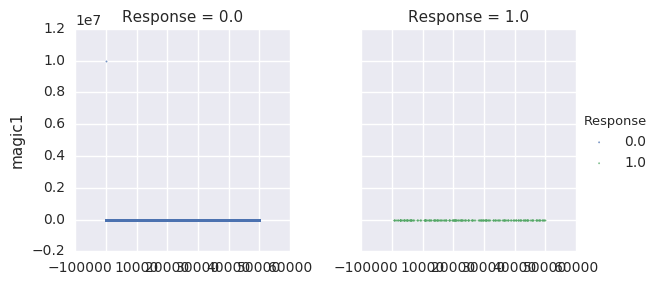

In [7]:
twoplot(train, 'magic1')

Doesn't look very discriminating

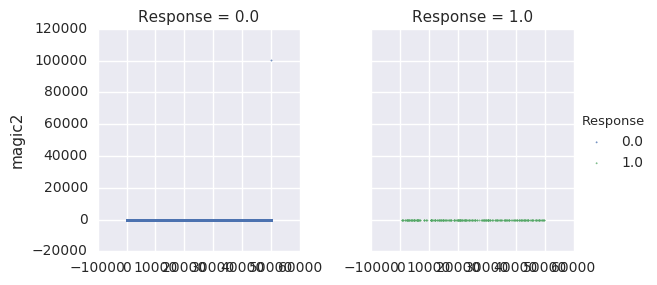

In [8]:
twoplot(train, 'magic2')

Still doesn't look very discriminating

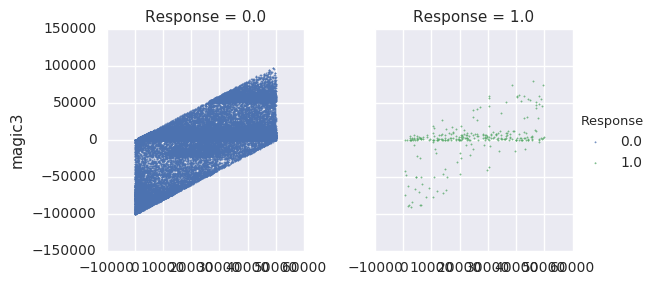

In [9]:
twoplot(train, 'magic3')

The two plots are clearly different and there seems to be some signal. It's not as clear as putting a threshold to identify response 0 vs response 1. But XGboost can use this signal (as is apparent from leaderboard positions of those using it)

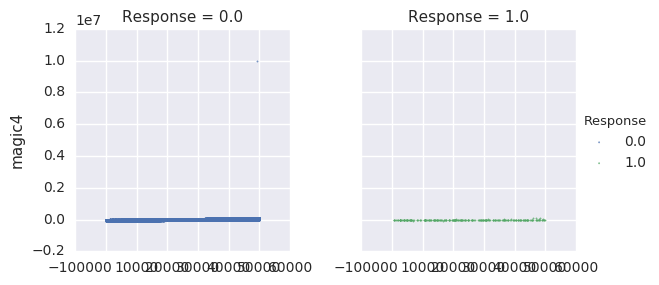

In [10]:
twoplot(train, 'magic4')

Looks similar to magic3 in shape but the graph is skewed because there is an outlier in the left hand side plot to the far right at value 1.0-1e7

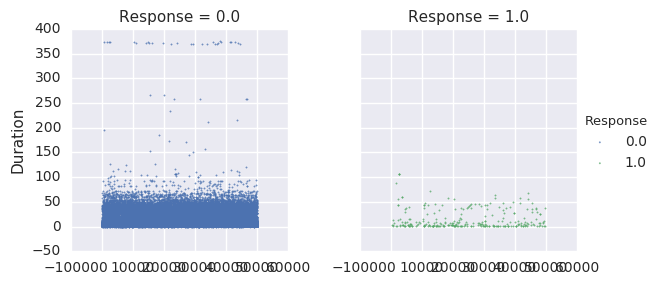

In [11]:
twoplot(train, 'Duration')

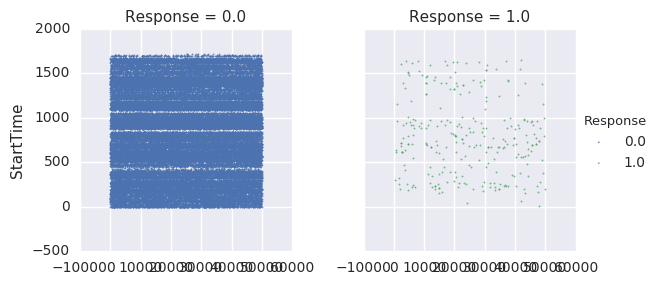

In [12]:
twoplot(train, 'StartTime')

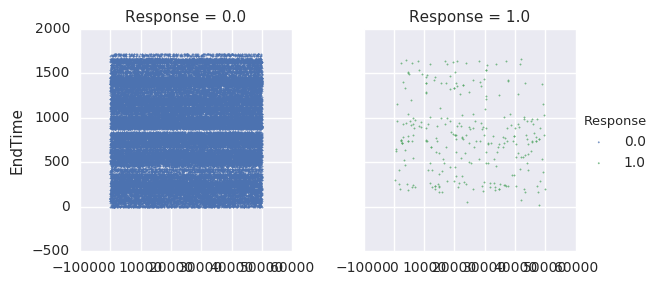

In [13]:
twoplot(train, 'EndTime')